# PRÁCTICA 1


In [164]:
import cv2  
import numpy as np
import matplotlib.pyplot as plt
import csv

## TAREA 1: 

Los ejemplos ilustrativos anteriores permiten saber el número de monedas presentes en la imagen. ¿Cómo saber la cantidad de dinero presente en ella? Sugerimos identificar de forma interactiva (por ejemplo haciendo clic en la imagen) una moneda de un valor determinado en la imagen (por ejemplo de 1€). Tras obtener esa información y las dimensiones en milímetros de las distintas monedas, realiza una propuesta para estimar la cantidad de dinero en la imagen. Muestra la cuenta de monedas y dinero sobre la imagen. No hay restricciones sobre utilizar medidas geométricas o de color. 

Una vez resuelto el reto con la imagen ideal proporcionada, captura una o varias imágenes con monedas. Aplica el mismo esquema, tras identificar la moneda del valor determinado, calcula el dinero presente en la imagen. ¿Funciona correctamente? ¿Se observan problemas?

Nota: Para establecer la correspondencia entre píxeles y milímetros, comentar que la moneda de un euro tiene un diámetro de 23.25 mm. la de 50 céntimos de 24.35, la de 20 céntimos de 22.25, etc. 

Extras: Considerar que la imagen pueda contener objetos que no son monedas y/o haya solape entre las monedas. Demo en vivo. 

Contornos de las Monedas: 10
Moneda 1: Centro=(366, 814), Ejes=(205, 210), Ángulo=91°
Moneda 2: Centro=(366, 814), Ejes=(191, 196), Ángulo=89°
Moneda 3: Centro=(366, 814), Ejes=(183, 188), Ángulo=88°
Moneda 4: Centro=(366, 814), Ejes=(166, 171), Ángulo=85°
Moneda 5: Centro=(366, 814), Ejes=(156, 159), Ángulo=85°
Moneda 6: Centro=(366, 814), Ejes=(150, 152), Ángulo=83°
Moneda 7: Centro=(366, 814), Ejes=(171, 173), Ángulo=90°
Moneda 8: Centro=(366, 814), Ejes=(124, 131), Ángulo=5°
Moneda 9: Centro=(366, 814), Ejes=(25, 50), Ángulo=83°
Moneda 10: Centro=(366, 814), Ejes=(16, 58), Ángulo=12°

Total monedas detectadas: 10


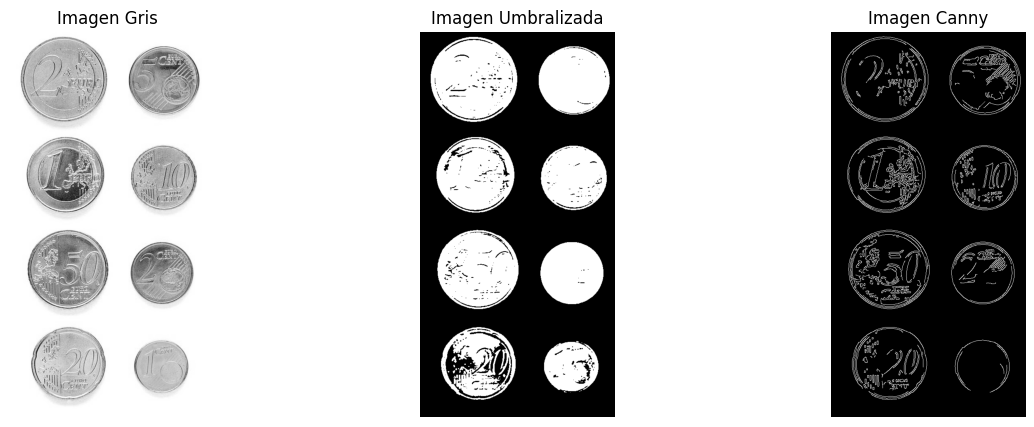

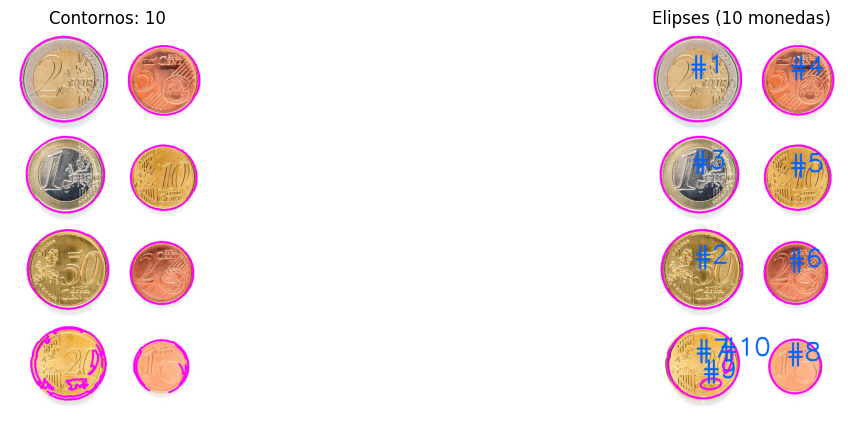

In [ ]:

monedas = cv2.imread('imgs/Monedas.jpg')
#monedas = cv2.imread('imgs/Euro_coins_shadow.jpg')
#monedas = cv2.imread('imgs/Euro_coins_sofa.jpeg')
#monedas = cv2.imread('imgs/Euro_coins_background.jpg')
#monedas = cv2.imread('imgs/Euro_coins_hand.jpg')


monedas_rgb = cv2.cvtColor(monedas, cv2.COLOR_BGR2RGB)
monedas_gris = cv2.cvtColor(monedas, cv2.COLOR_BGR2GRAY)


monedas_blurr = cv2.GaussianBlur(monedas_gris, (5,5), 0)

umbral = 200
umbral_usado_inv,umbralizado_invertido = cv2.threshold(monedas_blurr, umbral, 255, cv2.THRESH_BINARY_INV)

umbral_inf = 100
umbral_sup = 200
umbralizado_canny = cv2.Canny(monedas_blurr, umbral_inf, umbral_sup)

plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)
plt.axis("off")
plt.title("Imagen Gris")
plt.imshow(monedas_gris, cmap="gray")
plt.subplot(1,3,2)
plt.axis("off")
plt.title("Imagen Umbralizada")
plt.imshow(umbralizado_invertido, cmap="gray")
plt.subplot(1,3,3)
plt.axis("off")
plt.title("Imagen Canny")
plt.imshow(umbralizado_canny, cmap="gray")
plt.show

kernel = np.ones((3, 3), np.uint8)
monedas_umbralizadas = cv2.morphologyEx(umbralizado_canny, cv2.MORPH_CLOSE, kernel, iterations=2)

contornos, hierarchy = cv2.findContours(
    monedas_umbralizadas, #imagen
    cv2.RETR_EXTERNAL, # únicamente contornos externos
    cv2.CHAIN_APPROX_SIMPLE #Método de aproximación del contorno
    )

coins_d = {
    '200': 25.75,
    '100': 23.25,
    '50': 24.25,
    '20': 22.25,
    '10': 19.75,
    '5': 21.25,
    '2': 18.75,
    '1': 16.25
}

coins_invert = {v: int(k) for k, v in coins_d.items()}

contornos = [c for c in contornos if cv2.contourArea(c) > 500]
contornos = sorted(contornos, key=lambda c: cv2.contourArea(c), reverse=True)

print(f"Contornos de las Monedas: {len(contornos)}")

monedas_rgb_contoures = monedas_rgb.copy()
cv2.drawContours(monedas_rgb_contoures, contornos, -1, (255,0,255), 3)

"""
plt.subplot(1,3,1)
plt.axis("off")
plt.title("Contornos")
plt.imshow(monedas_rgb)
"""

monedas_rgb_elipses = monedas_rgb.copy()
monedas_detectadas = 0
for i, contorno in enumerate(contornos):
    if len(contorno) >= 5:  # fitEllipse requiere mínimo 5 puntos
        try:
            ellipse = cv2.fitEllipse(contorno)
            coordinates, (MA, ma), angle = ellipse
            area = cv2.contourArea(contorno)
            

                # Dibujar elipse
            cv2.ellipse(monedas_rgb_elipses, ellipse, (255, 0, 255), 3)
                
                
            monedas_detectadas += 1
            cv2.putText(monedas_rgb_elipses, f"#{monedas_detectadas}",
                           (int(coordinates[0]) - 20, int(coordinates[1]) - 15),
                           cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 100, 255), 3)
                
            print(f"Moneda {monedas_detectadas}: Centro={center}, "
                      f"Ejes=({int(MA)}, {int(ma)}), Ángulo={int(angle)}°")
        
        except cv2.error as e:
            print(f"Error en contorno {i}: {e}")

print(f"\nTotal monedas detectadas: {monedas_detectadas}")

# Mostrar resultados
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title(f"Contornos: {len(contornos)}")
plt.imshow(monedas_rgb_contoures)

plt.subplot(1, 2, 2)
plt.axis("off")
plt.title(f"Elipses ({monedas_detectadas} monedas)")
plt.imshow(monedas_rgb_elipses)


## Tarea 2:

El objetivo de la siguiente tarea, descrita más abajo, es desarrollar tu propio clasificador basado únicamente en heurísticas basadas en características geométricas y/o de apariencia, a partir de las imágenes completas de las partículas de cada tipo, debiendo mostrar la bondad del clasificador haciendo uso de métricas para ello sobre las anotaciones de la imagen de test *MPs_test.png*. La siguiente celda obtiene varias métricas para un conjunto de datos imaginario (y con etiquetas aleatorias). Si bien las trataremos con más detalle en teoría, muestro un repertorio de ellas, dando más peso a la matriz de confusión. La ejecución de la celda requiere instalar el paquete scikit-learn.

¿Qué es una matriz de confusión?
Se utiliza para mostrar el comportamiento de un clasificador para las distintas clases conocidas, se relacionan las etiquetas de las muestras anotadas frente a las predichas por el clasificador. Se busca una matriz diagonal, pero la perfección es infrecuente.

El siguiente ejemplo, muestra el modo de obtener la matriz de confusión para un hipotético problema con cuatro clases, y valores de anotación (variable y) y predicción (variable y_pred) obtenidos de forma aleatoria.
TAREA: La tarea consiste en extraer características (geométricas y/o visuales) de las tres imágenes completas de partida, y *aprender* patrones que permitan identificar las partículas en nuevas imágenes. Para ello se proporciona como imagen de test *MPs_test.jpg* y sus correpondientes anotaciones *MPs_test_bbs.csv* con la que deben obtener las métricas para su propuesta de clasificación de microplásticos, además de la matriz de confusión. La matriz de confusión permitirá mostrar para cada clase el número de muestras que se clasifican correctamente de dicha clase, y el número de muestras que se clasifican incorrectamente como perteneciente a una de las otras dos clases.

En el trabajo [SMACC: A System for Microplastics Automatic Counting and Classification](https://doi.org/10.1109/ACCESS.2020.2970498), las características geométricas utilizadas fueron:

- Área en píxeles
- Perímetro en píxeles
- Compacidad (relación entre el cuadrado del perímetro y el área de la partícula)
- Relación del área de la partícula con la del contenedor
- Relación del ancho y el alto del contenedor
- Relación entre los ejes de la elipse ajustada
- Definido el centroide, relación entre las distancias menor y mayor al contorno

Si no se quedan satisfechos con la segmentación obtenida, es el mundo real, también en el README comento técnicas recientes de segmentación, que podrían despertar su curiosidad.


# Características -> Traducción a OPENCV

Área en píxeles
area = cv2.contourArea(contour)
se consideran microplásticos cuando miden menos de 5mm


Perímetro en píxeles
Puede suavizarse el contorno (por ejemplo con un cv2.approxPolyDP) si el ruido es alto.
pixel = cv2.arcLength(contour, closed=True)


Compacidad (relación entre el cuadrado del perímetro y el área de la partícula)
Compacidad = (P^2)/A -> Inverso a la circularidad
Compacidad grande -> Contorno rugoso
Compacidad aproximada a 12.57(≈ 4 × π) -> Circular

Circularidad = (4πA)/(P^2)
 Circularidad = 1 / (Compacidad/4π)


Relación del área de la partícula con la del contenedor
ratio_Area = Area_particula/Area_contenedor
x, y, w, h = cv2.boundingRect(contour) # bounding box (rectángulo mínimo que contiene la partícula).
A_box = w * h
A_ratio = A / A_box


Relación del ancho y el alto del contenedor
E_Ratio = a/b (ejes de la elipse)
ellipse = cv2.fitEllipse(contour)
(xc, yc), (major_axis, ma), angle = ellipse
E_ratio = major_axis/ ma



Relación entre los ejes de la elipse ajustada



Definido el centroide, relación entre las distancias menor y mayor al contorno



# Función: extrae las características de la imagen

In [292]:
def geometric_features(contour):

    if len(contour) < 3:
        return {k: 0 for k in [
            "Area", "Perimeter", "Compacidad", "Circularity",
            "Area_ratio", "Aspect_ratio", "E_ratio", "D_ratio"
        ]}

    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    if perimeter == 0 or area == 0:
        return {k: 0 for k in [
            "Area", "Perimeter", "Compacidad", "Circularity",
            "Area_ratio", "Aspect_ratio", "E_ratio", "D_ratio"
        ]}

    compacity = (perimeter**2) / area # if perimeter > 0 or area > 0 else 0
    circularity = (4*np.pi*area) / (perimeter**2) # if perimeter > 0 or area > 0 else 0

    _, _, w, h = cv2.boundingRect(contour)
    box_area = w * h
    ratio_area = area / box_area if box_area > 0 else 0
    aspect_ratio = w / h if h > 0 else 0

    """
    E_ratio < 1.2 and D_ratio > 0.9 → circular.
    E_ratio > 2.5 or D_ratio < 0.5 → alargada.
    ratio_area < 0.6 and C > 20 → forma irregular.
    """ 
    e_ratio = 0
    if len(contour) >= 5:
        (_, _), (major_axis, minor_axis), _ = cv2.fitEllipse(contour)
        e_ratio = major_axis / minor_axis if minor_axis > 0 else 0

    d_ratio = 0
    M = cv2.moments(contour)
    if M["m00"] != 0:
        xc = M["m10"]/M["m00"]
        yc = M["m01"]/M["m00"]
        dist = np.sqrt((contour[:,0,0]-xc)**2 + (contour[:,0,1]-yc)**2)
        d_ratio = dist.min() / dist.max() if dist.max() > 0 else 0

    # return area, perimeter, compacity, circularity, ratio_area, AR, E_ratio, D_ratio
    return {
        "Area": area,
        "Perimeter": perimeter,
        "Compacidad": compacity,
        "Circularity": circularity,
        "Area_ratio": ratio_area,
        "Aspect_ratio": aspect_ratio, 
        "E_ratio": e_ratio, 
        "D_ratio": d_ratio
    }
    

# Función: Umbralizado y contornos

In [294]:
def thresholds_and_image_manipulation(image):

    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blured_image = cv2.GaussianBlur(gray_image,(5,5),0)

    threshold_image = cv2.adaptiveThreshold(blured_image,
                                             255,
                                             cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                             cv2.THRESH_BINARY,
                                             15,
                                             2)
    
    return threshold_image


# Funciones: Extraen y retorna los contornos

In [295]:
def extract_contours_from_image(image):

    modified_image = thresholds_and_image_manipulation(image)
    contours, _ = cv2.findContours(modified_image,
                                   cv2.RETR_EXTERNAL,
                                   cv2.CHAIN_APPROX_SIMPLE)
    
    return contours


def extract_region_from_bounding_box(image, x_min, y_min, x_max, y_max):
    return image[y_min:y_max, x_min:x_max]



# Función: Barrido con una ventana deslizante:

In [298]:
def sliding_window(image, window_size=64, stride=32):

    slides = []
    final_image = thresholds_and_image_manipulation(image)

    for y in range(0, final_image.shape[0] - window_size+1, stride):
            for x in range(0, final_image.shape[1] - window_size+1, stride):
                  
                window = final_image[y:y+window_size, x:x+window_size]
                slides.append({"x":x, "y":y, "window":window})

    return slides


# Entrenamiento

In [301]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns


labels = {
    "pellet": (0,255,0),
    "fragmento": (255,0,0),
    "alquitrán": (0,0,255)
}

training_images = {
    "pellet": "imgs/pellet-03-olympus-10-01-2020.JPG",
    "fragmento": "imgs/fragment-03-olympus-10-01-2020.JPG",
    "alquitrán": "imgs/tar-03-olympus-10-01-2020.JPG"
}


X, Y = [], []
feature_names = None

for label_name,label_image_path in training_images.items():

    current_training_image = cv2.imread(label_image_path)

    if current_training_image is None:
        raise FileNotFoundError(f"No se enontró ninguna imagen en el directorio: {label_image_path}")

    """
    regions = sliding_window(current_training_image)
    for region in regions:
        region_feature, = geometric_features(region[2])
        X.append(region_feature)
        Y.append(i)
    """

    #current_training_image = thresholds_and_image_manipulation(current_training_image)
    #current_contours, _ = cv2.findContours(current_training_image)
    current_contours = extract_contours_from_image(current_training_image)
    print(f"Contornos detectados de la imagen de {label_name}: {len(current_contours)}")

    for contour in current_contours:
        current_features = geometric_features(contour)
        # Rellenar NaN con 0 o media
        # TODO: Devolver lista en la función para usar el método filter al resultado y poner la condición 
        # current_features = {k: (v if not np.isnan(v) else 0) for k, v in current_features.items()}
        
        if feature_names is None:
            feature_names = list(current_features.keys())

        X.append(list(current_features.values()))
        Y.append(label_name)

X = np.array(X)
Y = np.array(Y)

print(f"Muestras de entrenamiento: {len(X)}")
print(f"Características: {feature_names}")
print(f"Distribución de clases: {np.unique(Y, return_counts=True)}")


scaler = StandardScaler() # x_scaled = (x - mean) / standard_deviation
X_train_scaled = scaler.fit_transform(X)

print("\nEntrenando Random Forest...")
clf = RandomForestClassifier(n_estimators=100,
                            random_state=42, 
                            max_depth=10,
                            min_samples_split=5,
                            min_samples_leaf=2,
                            n_jobs=1)
clf.fit(X_train_scaled, Y)
print("fin del entrenamiento")


Contornos detectados de la imagen de pellet: 1
Contornos detectados de la imagen de fragmento: 11
Contornos detectados de la imagen de alquitrán: 5
Muestras de entrenamiento: 17
Características: ['Area', 'Perimeter', 'Compacidad', 'Circularity', 'Area_ratio', 'Aspect_ratio', 'E_ratio', 'D_ratio']
Distribución de clases: (array(['alquitrán', 'fragmento', 'pellet'], dtype='<U9'), array([ 5, 11,  1]))

Entrenando Random Forest...
fin del entrenamiento


# Predicción en Test

In [303]:
test_image_path = "imgs/MPs_test.jpg"
test_bbs_path = "imgs/MPs_test_bbs.csv"

label_mapping = {
    'PEL': 'pellet',
    'FRA': 'fragmento',
    'TAR': 'alquitrán'
}

x_test = []
y_true = []
y_true_raw = []
test_countours = []
bounding_boxes = []

test_image = cv2.imread(test_image_path)
if current_training_image is None:
    raise FileNotFoundError(f"No se enontró ninguna imagen en el directorio: {label_image_path}")


test_annotations_df = pd.read_csv(test_bbs_path)
if test_annotations_df is None:
    raise FileNotFoundError(f"No se enontró csv en el directorio: {test_bbs_path}")

test_annotations_df['label_mapped'] = test_annotations_df['label'].map(label_mapping)

for id_x, row in test_annotations_df.iterrows():
    x_min, y_min, x_max, y_max = int(row["x_min"]), int(row["y_min"]), int(row["x_max"]), int(row["y_max"])
    label = row["label"]

    region = extract_region_from_bounding_box(test_image, x_min, y_min, x_max, y_max)
    current_contours = extract_contours_from_image(region)

    for contour in current_contours:
        current_features = geometric_features(contour)
        x_test.append(list(current_features.values()))
        y_true.append(label_mapping[label])
        y_true_raw.append(label)
        test_countours.append(contour)
        bounding_boxes.append((x_min, y_min, x_max, y_max))        

x_test = np.array(x_test)
y_true = np.array(y_true)

print(f"Muestras de test: {len(x_test)}")

x_test_scaled = scaler.transform(x_test)
y_pred = clf.predict(x_test_scaled)


Muestras de test: 277


# Métricas de Evaluación:


MÉTRICAS:
Accuracy: 0.4549
Precision: 0.2069
Recall: 0.4549
F1-Score: 0.2844

              precision    recall  f1-score   support

   alquitrán       0.00      0.00      0.00        52
   fragmento       0.45      1.00      0.63       126
      pellet       0.00      0.00      0.00        99

    accuracy                           0.45       277
   macro avg       0.15      0.33      0.21       277
weighted avg       0.21      0.45      0.28       277


Matriz de confusión: 
[[  0  52   0]
 [  0 126   0]
 [  0  99   0]]


c:\Users\asmae\anaconda3\envs\VC_P3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\asmae\anaconda3\envs\VC_P3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\asmae\anaconda3\envs\VC_P3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape

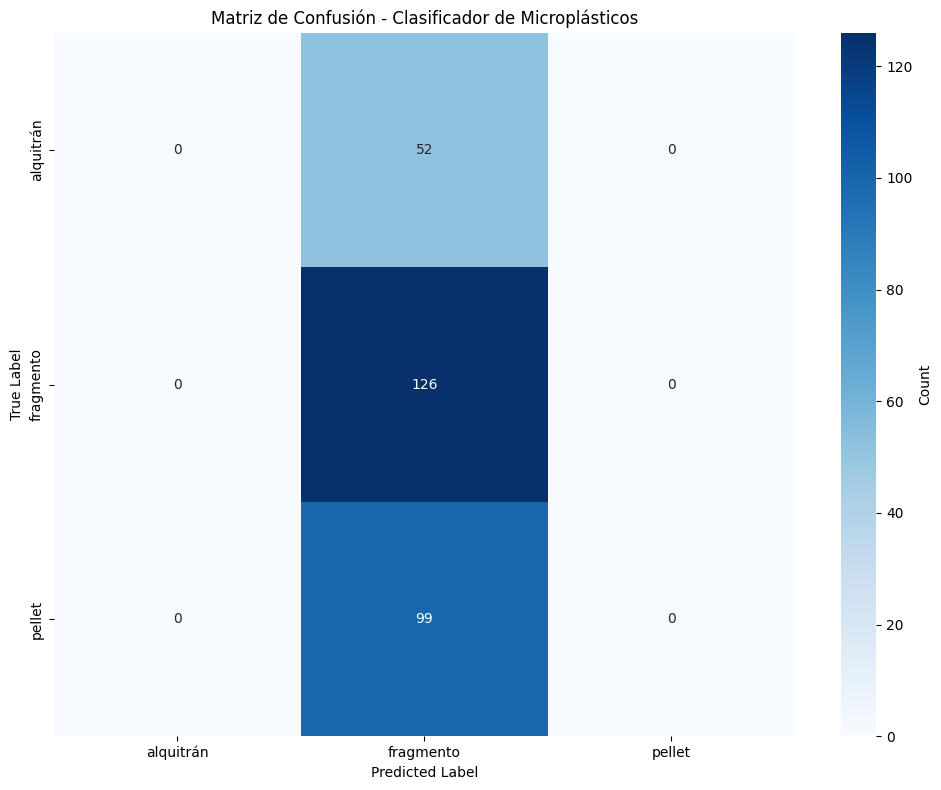

In [304]:
print("\nMÉTRICAS:")

accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")

precision = precision_score(y_true, y_pred, average="weighted", zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

print(f"\n{classification_report(y_true, y_pred, labels=clf.classes_)}")


c_matrix = confusion_matrix(y_true, y_pred, labels=clf.classes_)
print(f"\nMatriz de confusión: ")
print(c_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(c_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=clf.classes_, 
            yticklabels=clf.classes_,
            cbar_kws={'label': 'Count'})
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Matriz de Confusión - Clasificador de Microplásticos')
plt.tight_layout()
plt.show()

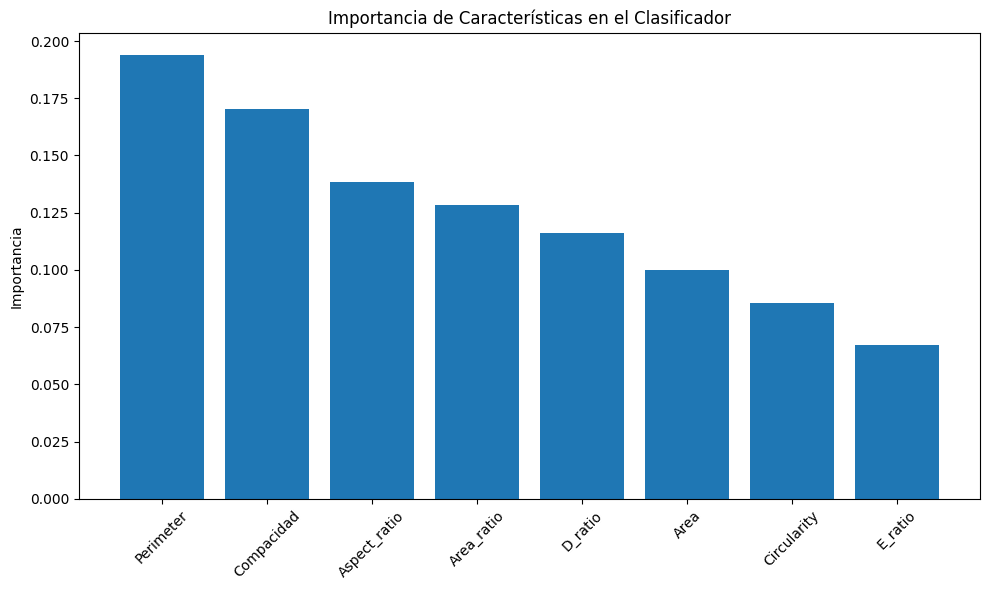

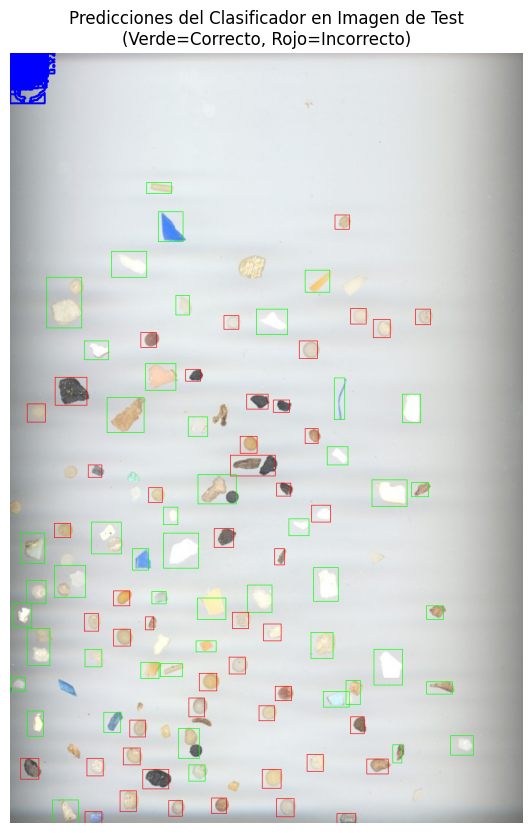

In [309]:
# Importancia de características
plt.figure(figsize=(10, 6))
feature_importance = clf.feature_importances_
indices = np.argsort(feature_importance)[::-1]
plt.bar(range(len(feature_importance)), feature_importance[indices])
plt.xticks(range(len(feature_importance)), [feature_names[i] for i in indices], rotation=45)
plt.ylabel('Importancia')
plt.title('Importancia de Características en el Clasificador')
plt.tight_layout()
plt.show()

# Visualizar predicciones en la imagen de test
image_viz = test_image
colors = {class_name: labels[class_name] for class_name in clf.classes_}

# Dibujar contornos con sus predicciones
for contour, pred in zip(test_countours, y_pred):
    color = colors[pred]
    cv2.drawContours(image_viz, [contour], 0, color, 2)

# Dibujar también los bounding boxes
for (x_min, y_min, x_max, y_max), true_label, pred_label in zip(bounding_boxes, y_true, y_pred):
    # Verde si es correcto, rojo si es incorrecto
    color = (0, 255, 0) if true_label == pred_label else (0, 0, 255)
    cv2.rectangle(image_viz, (x_min, y_min), (x_max, y_max), color, 1)

plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(image_viz, cv2.COLOR_BGR2RGB))
plt.title('Predicciones del Clasificador en Imagen de Test\n(Verde=Correcto, Rojo=Incorrecto)')
plt.axis('off')
plt.show()

# Dibujar microplásticos clasificados